Computer Vision Project : Albin Joyeux, Simon Zarka-Arthus, Victor Vaissié, Mohammed Anezary, Ouissal Jamai

In [ ]:
import os
import shutil

# Create a directory for Kaggle API credentials
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file to the appropriate location
shutil.move("kaggle.json", "/root/.kaggle/")

# Set the correct permissions
os.chmod("/root/.kaggle/kaggle.json", 600)


FileNotFoundError: [Errno 2] No such file or directory: 'kaggle.json'

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
100% 1.44G/1.45G [00:10<00:00, 136MB/s]
100% 1.45G/1.45G [00:10<00:00, 142MB/s]


In [ ]:
import zipfile

dataset_name = "wildfire-prediction-dataset.zip"  # Change to the actual filename
with zipfile.ZipFile(dataset_name, "r") as zip_ref:
    zip_ref.extractall("dataset")

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from PIL import ImageFile, Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models import resnet18


In [ ]:
# Define paths
DATASET_PATH = "./dataset"
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VALID_DIR = os.path.join(DATASET_PATH, "valid")
TEST_DIR = os.path.join(DATASET_PATH, "test")


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
NEW_TRAIN_DIR = os.path.join(DATASET_PATH, "new_train")
NEW_VAL_DIR = os.path.join(DATASET_PATH, "new_validation")

In [ ]:
# Create new directories
os.makedirs(NEW_TRAIN_DIR, exist_ok=True)
os.makedirs(NEW_VAL_DIR, exist_ok=True)

# Iterate through each class folder
for class_name in os.listdir(VALID_DIR):
    class_dir = os.path.join(VALID_DIR, class_name)

    if os.path.isdir(class_dir):
        # Create corresponding class directories in new_train and new_validation
        os.makedirs(os.path.join(NEW_TRAIN_DIR, class_name), exist_ok=True)
        os.makedirs(os.path.join(NEW_VAL_DIR, class_name), exist_ok=True)

        # List all images in this class
        images = os.listdir(class_dir)

        # Split into new train and validation sets (e.g., 80% train, 20% validation)
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        # Move images to the new directories
        for img in train_images:
            shutil.move(os.path.join(class_dir, img), os.path.join(NEW_TRAIN_DIR, class_name, img))

        for img in val_images:
            shutil.move(os.path.join(class_dir, img), os.path.join(NEW_VAL_DIR, class_name, img))

print("Splitting complete! New train and validation sets are created.")


Splitting complete! New train and validation sets are created.


## Feature Extraction using FCN ResNet50

In [ ]:
# Data augmentation & normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(NEW_TRAIN_DIR, transform=transform)
val_dataset = datasets.ImageFolder(NEW_VAL_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
# Load pre-trained FCN ResNet50 as feature extractor
unet = fcn_resnet50(pretrained=True)
unet.eval()  # Disable training
unet = unet.to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:00<00:00, 170MB/s]


In [ ]:
# Extract features from Unet
def extract_features(model, dataloader):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    features, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            feat = model(images)['out'].mean(dim=(2, 3))  # Global avg pooling
            features.append(feat.cpu())
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)

train_features, train_labels = extract_features(unet, train_loader)
val_features, val_labels = extract_features(unet, val_loader)
test_features, test_labels = extract_features(unet, test_loader)

In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

num_classes = len(train_dataset.classes)
classifier = Classifier(train_features.shape[1], num_classes).to("cuda" if torch.cuda.is_available() else "cpu")

# Training classifier
clf_criterion = nn.CrossEntropyLoss()
clf_optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

In [ ]:
def train_classifier(model, train_features, train_labels, val_features, val_labels, epochs=100):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_features, train_labels = train_features.to(device), train_labels.to(device)
    val_features, val_labels = val_features.to(device), val_labels.to(device)

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        clf_optimizer.zero_grad()
        outputs = model(train_features)
        loss = clf_criterion(outputs, train_labels)
        loss.backward()
        clf_optimizer.step()

        train_accuracy = (outputs.argmax(dim=1) == train_labels).float().mean().item()
        train_losses.append(loss.item())
        train_accuracies.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features)
            val_loss = clf_criterion(val_outputs, val_labels)
            val_accuracy = (val_outputs.argmax(dim=1) == val_labels).float().mean().item()
            val_losses.append(val_loss.item())
            val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}, Train Acc: {train_accuracy:.2f}, Val Acc: {val_accuracy:.2f}")

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Epoch 1, Train Loss: 0.7839798331260681, Val Loss: 0.5973525047302246, Train Acc: 0.46, Val Acc: 0.64
Epoch 2, Train Loss: 0.4658443331718445, Val Loss: 0.6008610129356384, Train Acc: 0.80, Val Acc: 0.64
Epoch 3, Train Loss: 0.42430177330970764, Val Loss: 0.5876905918121338, Train Acc: 0.83, Val Acc: 0.67
Epoch 4, Train Loss: 0.38968709111213684, Val Loss: 0.5388090014457703, Train Acc: 0.85, Val Acc: 0.72
Epoch 5, Train Loss: 0.3606046736240387, Val Loss: 0.47224923968315125, Train Acc: 0.86, Val Acc: 0.77
Epoch 6, Train Loss: 0.33227789402008057, Val Loss: 0.4090375602245331, Train Acc: 0.87, Val Acc: 0.81
Epoch 7, Train Loss: 0.3166801631450653, Val Loss: 0.3643803000450134, Train Acc: 0.88, Val Acc: 0.84
Epoch 8, Train Loss: 0.30466529726982117, Val Loss: 0.337045282125473, Train Acc: 0.88, Val Acc: 0.87
Epoch 9, Train Loss: 0.3032136559486389, Val Loss: 0.32175397872924805, Train Acc: 0.88, Val Acc: 0.87
Epoch 10, Train Loss: 0.29656821489334106, Val Loss: 0.3124978542327881, Trai

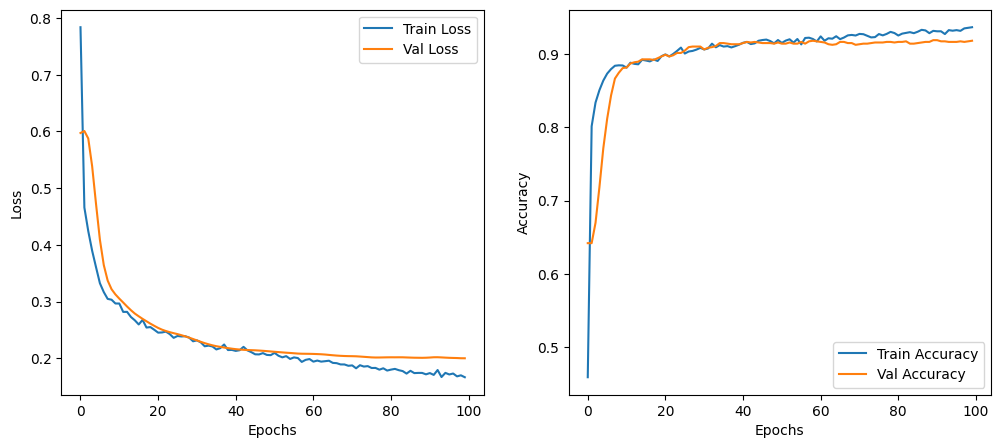

In [ ]:
train_classifier(classifier, train_features, train_labels, val_features, val_labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Accuracy: 92.92%
Precision: 0.9292
Recall: 0.9292
F1 Score: 0.9292


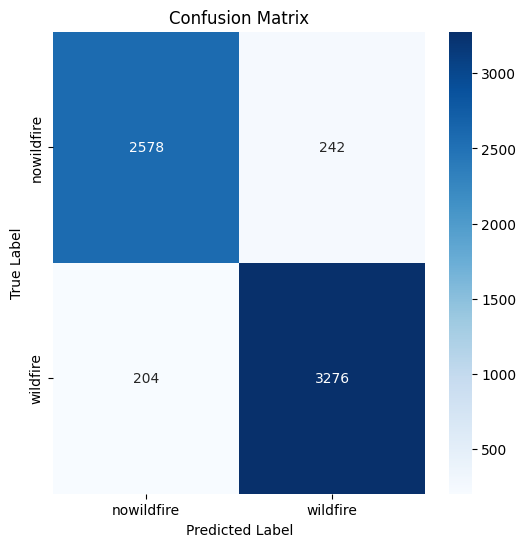

In [ ]:
# Evaluate model with metrics
def evaluate_model_metrics(model, test_features, test_labels):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    test_features, test_labels = test_features.to(device), test_labels.to(device)

    with torch.no_grad():
        outputs = model(test_features)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true = test_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, predictions) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, predictions, average='weighted')

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model_metrics(classifier, test_features, test_labels)

## Classification using ResnNet

In [ ]:
# Define image transformations (resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard for ImageNet
])

# Load datasets
train_dataset = datasets.ImageFolder(root=NEW_TRAIN_DIR, transform=transform)
val_dataset = datasets.ImageFolder(root=NEW_VAL_DIR, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = train_dataset.classes

In [ ]:
# Load pretrained ResNet model
resnet = models.resnet18(pretrained=True)

# Modify the final classification layer
num_classes = len(class_names)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.5MB/s]


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

    print("Training Complete!")

def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Train for 10 epochs
train_model(resnet, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1: Loss=0.2075, Train Acc=92.10%, Val Acc=95.95%
Epoch 2: Loss=0.3955, Train Acc=84.27%, Val Acc=92.06%
Epoch 3: Loss=0.2311, Train Acc=91.45%, Val Acc=91.51%
Epoch 4: Loss=0.1797, Train Acc=93.13%, Val Acc=92.94%
Epoch 5: Loss=0.1636, Train Acc=93.83%, Val Acc=94.52%
Epoch 6: Loss=0.1504, Train Acc=94.40%, Val Acc=95.32%
Epoch 7: Loss=0.1548, Train Acc=94.01%, Val Acc=95.71%
Epoch 8: Loss=0.1529, Train Acc=94.76%, Val Acc=94.76%
Epoch 9: Loss=0.1331, Train Acc=95.08%, Val Acc=95.56%
Epoch 10: Loss=0.1564, Train Acc=94.62%, Val Acc=94.60%
Training Complete!


In [ ]:
torch.save(resnet.state_dict(), "resnet_wildfire.pth")

In [ ]:
resnet.load_state_dict(torch.load("resnet_wildfire.pth"))
resnet.eval()

<ipython-input-22-7df565dacb3d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load("resnet_wildfire.pth"))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Load test dataset
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = test_dataset.classes

Accuracy: 95.90%
Precision: 0.9595
Recall: 0.9590
F1 Score: 0.9590


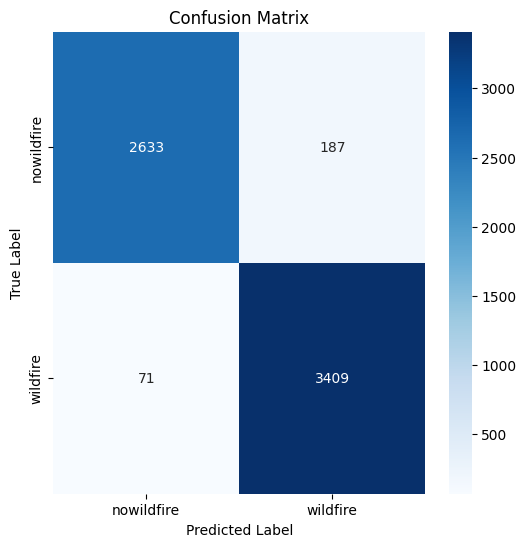

In [ ]:
def evaluate_model_metrics(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Store true labels and predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run the evaluation
evaluate_model_metrics(resnet, test_loader)


## With DenseNet

In [ ]:
from torchvision.models import densenet121
from torchvision.models.segmentation import fcn_resnet50

In [ ]:
# Load pre-trained DenseNet121 as feature extractor (replacing the FCN ResNet50)
densenet_model = densenet121(pretrained=True)
feature_extractor = nn.Sequential(*list(densenet_model.children())[:-1])
feature_extractor.eval()
feature_extractor = feature_extractor.to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def extract_features_densenet(model, dataloader):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    features, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            # Apply the features extractor and then apply global average pooling
            output = model(images)
            # Properly reshape the output - DenseNet needs explicit pooling
            output = F.adaptive_avg_pool2d(output, (1, 1)).view(images.size(0), -1)
            features.append(output.cpu())
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)

In [ ]:
# Extract features using  function
train_features, train_labels = extract_features_densenet(feature_extractor, train_loader)
val_features, val_labels = extract_features_densenet(feature_extractor, val_loader)
test_features, test_labels = extract_features_densenet(feature_extractor, test_loader)

In [ ]:
# Update classifier to match DenseNet feature dimensions (1024 for DenseNet121)
class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetClassifier, self).__init__()
        self.fc1 = nn.Linear(1024, 512)  # DenseNet121 outputs 1024 features
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
# Create and train the new classifier
num_classes = len(train_dataset.classes)
classifier = DenseNetClassifier(num_classes).to("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Training classifier (using your existing train_classifier function)
clf_criterion = nn.CrossEntropyLoss()
clf_optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

Epoch 1, Train Loss: 0.7597000598907471, Val Loss: 0.5523879528045654, Train Acc: 0.50, Val Acc: 0.90
Epoch 2, Train Loss: 0.32008096575737, Val Loss: 0.4288467764854431, Train Acc: 0.90, Val Acc: 0.91
Epoch 3, Train Loss: 0.23297521471977234, Val Loss: 0.3267368972301483, Train Acc: 0.91, Val Acc: 0.92
Epoch 4, Train Loss: 0.2039255052804947, Val Loss: 0.25033900141716003, Train Acc: 0.92, Val Acc: 0.93
Epoch 5, Train Loss: 0.17945446074008942, Val Loss: 0.19930225610733032, Train Acc: 0.93, Val Acc: 0.94
Epoch 6, Train Loss: 0.164109468460083, Val Loss: 0.16900251805782318, Train Acc: 0.94, Val Acc: 0.94
Epoch 7, Train Loss: 0.14704245328903198, Val Loss: 0.15257583558559418, Train Acc: 0.95, Val Acc: 0.94
Epoch 8, Train Loss: 0.14041168987751007, Val Loss: 0.14384298026561737, Train Acc: 0.95, Val Acc: 0.94
Epoch 9, Train Loss: 0.12814204394817352, Val Loss: 0.1385684609413147, Train Acc: 0.95, Val Acc: 0.94
Epoch 10, Train Loss: 0.11879392713308334, Val Loss: 0.1341024935245514, Tr

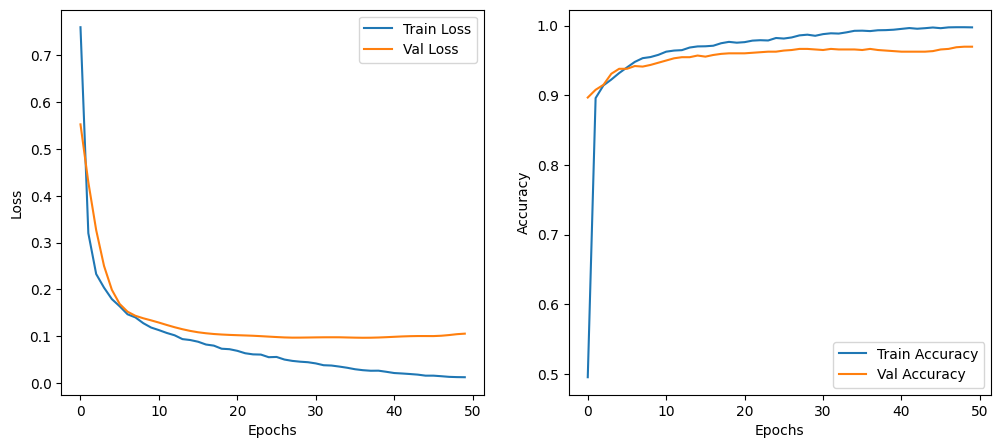

In [ ]:
# Train the classifier
train_classifier(classifier, train_features, train_labels, val_features, val_labels, epochs=50)


Accuracy: 97.49%
Precision: 0.9749
Recall: 0.9749
F1 Score: 0.9749


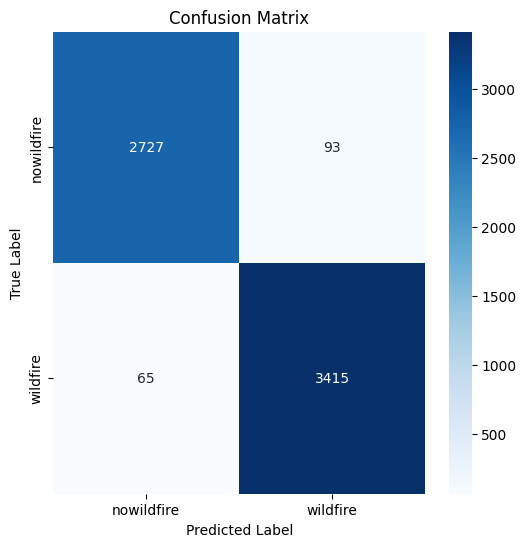

In [ ]:
# Evaluate the model
def evaluate_model_metrics_dense(model, test_features, test_labels):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    test_features, test_labels = test_features.to(device), test_labels.to(device)

    with torch.no_grad():
        outputs = model(test_features)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true = test_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, predictions) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, predictions, average='weighted')

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Then call it
evaluate_model_metrics_dense(classifier, test_features, test_labels)